<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Subreddit Classifier with Webscraping, NLP and ML
## Part 3: Modelling & Evaluation

## Contents:
1. [Import data](#Import-data)
2. [Train-test split](#Train-test-split)
3. [Modelling](#Modelling)
4. [Results Analysis](#Results-Analysis)
5. [Feature Importance](#Feature-Importance)
6. [ROC AUC Curve](#ROC-AUC-Curve)
7. [Conclusion & Recommendations](#Conclusion-&-Recommendations)
8. [References](#References)

In [1]:
# Import libraries
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_style('white')

## Import data
*Back to [Contents](#Contents:)*

In [2]:
df = pd.read_csv('./data/final_df.csv')

In [3]:
df.shape

(5329, 4)

In [4]:
# Mapping Bicycling subreddits to 0 and Motorcycles subreddits to 1 
df['bike'] = df['subreddit'].map({'bicycling':0, 'motorcycles':1})

In [5]:
df['bike'].value_counts(normalize=True)

0    0.535185
1    0.464815
Name: bike, dtype: float64

Baseline accuracy will be set at 53.7% and used to check the performance of our models.

In [6]:
df.head()

,subreddit,text,stem_text,lem_text,bike
0,bicycling,$10 off any RoadID,10 off ani roadid,10 off any roadid,0
1,bicycling,Is this a good deal on a bike? It’s a Fuji Thr...,is thi a good deal on a bike it s a fuji thril...,is this a good deal on a bike it s a fuji thri...,0
2,bicycling,"Hi, so there's been a string of bike theft in ...",hi so there s been a string of bike theft in m...,hi so there s been a string of bike theft in m...,0
3,bicycling,Specialized Hardrock. Winnipeg Red River singl...,special hardrock winnipeg red river singl trac...,specialized hardrock winnipeg red river single...,0
4,bicycling,Specialized Hardrock. Winnipeg Red river Canop...,special hardrock winnipeg red river canopi sin...,specialized hardrock winnipeg red river canopy...,0


## Train-test split
- We will have 3 sets of data: one from the main base text, one that is stemmed and one that is lemmatized
- All 3 sets will be passed into the models to see which has the better performance.

*Back to [Contents](#Contents:)*

In [7]:
X = df['text']
X_stem = df['stem_text']
X_lem = df['lem_text']
y = df['bike']

In [8]:
# Check if data is balanced or imbalanced
y.value_counts(normalize=True)

0    0.535185
1    0.464815
Name: bike, dtype: float64

In [9]:
# Split the main text data into the training and testing sets.
X_main_train, X_main_test, y_main_train, y_main_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [10]:
# Split the stem text data into the training and testing sets.
X_stem_train, X_stem_test, y_stem_train, y_stem_test = train_test_split(X_stem, y, test_size=0.3, stratify=y, random_state=42)

In [11]:
# Split the lemmatized text data into the training and testing sets.
X_lem_train, X_lem_test, y_lem_train, y_lem_test = train_test_split(X_lem, y, test_size=0.3, stratify=y, random_state=42)

## Modelling
- Model 0: CountVectorizer with LogisticRegression
- Creating a Randomized Search function to run different models
- Model 1: CountVectorizer with MultinomialNB (using main, stem and lem text)
- Model 2: TfidfVectorizer with MultinomialNB (using main, stem and lem text)
- Model 3: CountVectorizer with RandomForest (using main, stem and lem text)
- Model 4: TfidfVectorizer with RandomForest (using main, stem and lem text)

*Back to [Contents](#Contents:)*

### Model 0: CountVectorizer with LogisticRegression

In [12]:
# Use CountVectorizer and LogisticRegression to get a simple first model

cv_simple = CountVectorizer(stop_words='english')
X_train_cv = cv_simple.fit_transform(X_main_train)
X_test_cv = cv_simple.transform(X_main_test)

print("There are {} features in the model.".format(len(cv_simple.get_feature_names())))

lr_simple = LogisticRegression(solver='lbfgs')
lr_simple.fit(X_train_cv, y_main_train)
score_train = round(lr_simple.score(X_train_cv, y_main_train),4)
score_test = round(lr_simple.score(X_test_cv, y_main_test),4)

print("Train score: {}".format(score_train))
print("Test score: {}".format(score_test))

There are 14062 features in the model.
Train score: 0.9777
Test score: 0.863


Looks like there is an issue of overfitting with this simple Logistic Regression model.

### Function to run different models and print results

In [13]:
# Remove general stopwords in the english language 
# Remove additional stop words

add_stop = ['bicycle', 'bicycles', 'bicycling', 'cyclist', 'cyclists', 'cycling',
            'motorcycle', 'motorcycles', 'motorbike', 'motorbikes', 'motor']

stoplist = stopwords.words('english') + add_stop

In [14]:
# Instantiate a dictionary to house Models' Scores
results = {}

In [15]:
# Define main function to run Pipeline + RandomizedSearchCV
def run_model_rs(pipeline, parameters, cv=3, kind='', model_name=''):
    
    # Instantiate RandomizedSearchCV
    rs = RandomizedSearchCV(pipeline,
                            parameters,
                            cv=cv,
                            verbose=1,
                            n_jobs=-1,
                            n_iter=25, 
                            random_state=42)
    
    # Start our timer.
    t0 = time.time()
    
    # Fit GridSearch to training data, either main text, stem text or lem text
    if kind=='main':
        X_train = X_main_train
        y_train = y_main_train
        X_test = X_main_test
        y_test = y_main_test
    elif kind=='stem':
        X_train = X_stem_train
        y_train = y_stem_train
        X_test = X_stem_test
        y_test = y_stem_test
    else:
        X_train = X_lem_train
        y_train = y_lem_train
        X_test = X_lem_test
        y_test = y_lem_test
    
    rs_model = rs.fit(X_train, y_train)
    
    # Stop our timer and print the result.
    print(f"Time taken: {round(time.time() - t0,2)} seconds")
    
    
    # Best mean score out of cross validation out of all parameters tested
    print('\n')
    print(f'Best Score: {round(rs.best_score_,4)}')
    
    # Best Paramenters
    print(f'Best Parameters: {rs.best_params_}')
    
    # Save best model
    print(f'Best Estimator: {rs.best_estimator_}')
    
    # Score model on training set.
    train_score = round(rs_model.score(X_train, y_train),4)
    print('\n')
    print(f'Training Accuracy Score: {train_score}')
    
    # Score model on testing set.
    test_score = round(rs_model.score(X_test, y_test),4)
    print(f'Testing Accuracy Score: {test_score}')
    
    # Generalization difference
    gen_diff = round((1 - test_score/train_score) * 100,4)
    print(f'Generalization Difference: {gen_diff}%')
    print('\n')
    
    # Predictions
    pred = rs.predict(X_test)
    
    # Calculate ROC_AUC score
    y_proba = rs.predict_proba(X_test)
    auc = round(roc_auc_score(y_test, y_proba[:,1]),4)
    
    # Confusion Matrix
    cm_df = pd.DataFrame(confusion_matrix(y_test, pred),
                         columns=['pred_bicycling', 'pred_motorcycles'],
                         index=['actual_bicycling', 'actual_motorcycles'])
    print('Confusion Matrix:')
    print(cm_df)
    print('\n')
    
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    
    # Print different metrics
    accuracy = round((tp + tn) / (tp + tn + fp + fn),4)
    print(f'Accuracy: {accuracy}')
    
    misclassification = round(1 - accuracy,4)
    print(f'Misclassification: {misclassification}') 
    
    sensitivity = round(tp / (tp + fn),4)
    print(f'Sensitivity/ Recall: {sensitivity}')
    
    specificity = round(tn / (tn + fp),4)
    print(f'Specificity: {specificity}')
    
    precision = round(tp / (tp + fp),4)
    print(f'Precision: {precision}')
    
    f1_score = round(2 * (sensitivity * precision) / (sensitivity + precision),4)
    print(f'F1 Score: {f1_score}')
    
    print(f'ROC AUC Score: {auc}')
    
    # 'Append' accuracy scores to 'results' dictinoary
    results[model_name] = [train_score, test_score, gen_diff,
                           misclassification, sensitivity, specificity, precision, f1_score, auc]
    
    plot_confusion_matrix(rs, X_test, y_test, cmap='Blues', values_format='d')

### Model 1: CountVectorizer with MultinomialNB
- 1.1 Using main text
- 1.2 Using stemmed text
- 1.3 Using lemmatized text

In [16]:
# Set up pipeline
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [17]:
# Set up hyperparemeters
params_cvec_nb = {
    'cvec__max_features': [3_000, 4_000, 5_000, 6_000, 7_000], # select n most common words in data
    'cvec__min_df': [2, 3], # remove terms that appear in less than n documents
    'cvec__max_df': [.85, .9, .95], # remove frequent terms in n% of documents
    'cvec__ngram_range': [(1,1), (1,2)], #try unigrams, or bigrams
    'cvec__stop_words': [stoplist]
}

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 11.49 seconds


Best Score: 0.8509
Best Parameters: {'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'wh

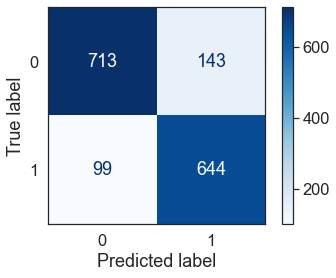

In [18]:
# Run Model 1.1: CountVectorizer with MultinomialNB using main text
run_model_rs(pipe_cvec_nb, params_cvec_nb, cv=5, kind='main', model_name='cvec_nb_main')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 8.9 seconds


Best Score: 0.8702
Best Parameters: {'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why'

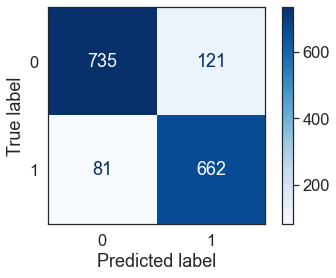

In [19]:
# Run Model 1.2: CountVectorizer with MultinomialNB using stemmed text
run_model_rs(pipe_cvec_nb, params_cvec_nb, cv=5, kind='stem', model_name='cvec_nb_stem')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 8.87 seconds


Best Score: 0.8507
Best Parameters: {'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why

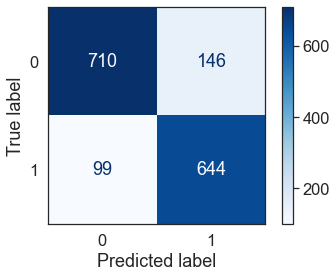

In [20]:
# Run Model 1.3: CountVectorizer with MultinomialNB using lemmatized text
run_model_rs(pipe_cvec_nb, params_cvec_nb, cv=5, kind='lem', model_name='cvec_nb_lem')

### Model 2: TfidfVectorizer with MultinomialNB
- 2.1 Using main text
- 2.2 Using stemmed text
- 2.3 Using lemmatized text

In [21]:
# Set up pipeline
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [22]:
# Set up hyperparemeters
params_tvec_nb = {
    'tvec__max_features': [3_000, 4_000, 5_000, 6_000, 7_000],
    'tvec__stop_words': [stoplist],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.8, 0.9]
}

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 10.36 seconds


Best Score: 0.8547
Best Parameters: {'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'wh

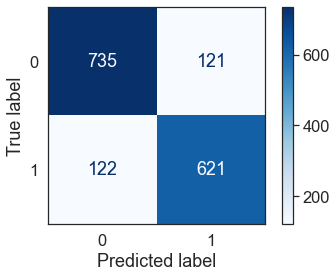

In [23]:
# Run Model 2.1: TfidfVectorizer with MultinomialNB with main text
run_model_rs(pipe_tvec_nb, params_tvec_nb, cv=5, kind='main', model_name='tvec_nb_main')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 10.14 seconds


Best Score: 0.8735
Best Parameters: {'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'wh

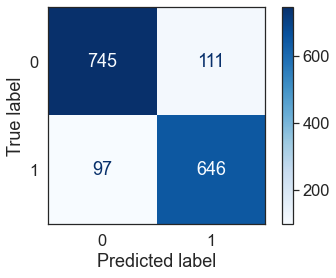

In [24]:
# Run Model 2.2: TfidfVectorizer with MultinomialNB with stemmed text
run_model_rs(pipe_tvec_nb, params_tvec_nb, cv=5, kind='stem', model_name='tvec_nb_stem')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 11.05 seconds


Best Score: 0.8582
Best Parameters: {'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'wh

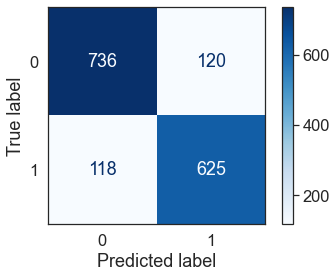

In [25]:
# Run Model 2.3: TfidfVectorizer with MultinomialNB with lemmatized text
run_model_rs(pipe_tvec_nb, params_tvec_nb, cv=5, kind='lem', model_name='tvec_nb_lem')

### Model 3: CountVectorizer with RandomForest
- 3.1 Using main text
- 3.2 Using stemmed text
- 3.3 Using lemmatized text

In [26]:
# Set up pipeline

pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [27]:
# Set up hyperparameters

params_cvec_rf = {
    'cvec__max_features': [2_000, 3_500, 5_000],
    'cvec__stop_words': [stoplist],
    'cvec__ngram_range': [(1,1), (1,2)],
    #'cvec__min_df': [0.01, 0.02, 0.03],
    #'cvec__max_df': [0.8, 0.9],
    
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 3, 5],
    #'rf__min_samples_split': [10, 20, 30],
    #'rf__min_samples_leaf':[5, 10, 15]
}

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 29.48 seconds


Best Score: 0.7989
Best Parameters: {'rf__n_estimators': 200, 'rf__max_depth': None, 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then

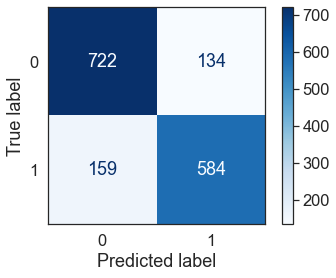

In [28]:
# Run Model 3.1: TfidfVectorizer with RandomForest with main text
run_model_rs(pipe_cvec_rf, params_cvec_rf, cv=5, kind='main', model_name='cvec_rf_main')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 28.3 seconds


Best Score: 0.8351
Best Parameters: {'rf__n_estimators': 200, 'rf__max_depth': None, 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then'

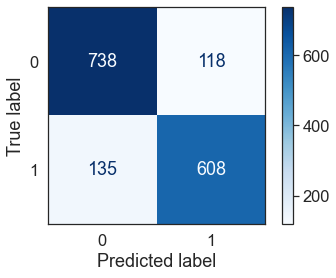

In [29]:
# Run Model 3.2: TfidfVectorizer with RandomForest with stemmed text
run_model_rs(pipe_cvec_rf, params_cvec_rf, cv=5, kind='stem', model_name='cvec_rf_stem')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 29.34 seconds


Best Score: 0.7992
Best Parameters: {'rf__n_estimators': 200, 'rf__max_depth': None, 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then

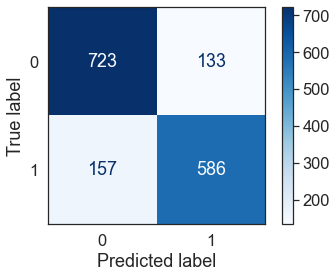

In [30]:
# Run Model 3.3: TfidfVectorizer with RandomForest with lemmatized text
run_model_rs(pipe_cvec_rf, params_cvec_rf, cv=5, kind='main', model_name='cvec_rf_lem')

### Model 4: TfidfVectorizer with RandomForest
- 4.1 Using main text
- 4.2 Using stemmed text
- 4.3 Using lemmatized text

In [31]:
# Set up pipeline

pipe_tvec_rf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [32]:
# Set up hyperparameters

params_tvec_rf = {
    'tvec__max_features': [2_000, 3_500, 5_000],
    'tvec__stop_words': [stoplist],
    'tvec__ngram_range': [(1,1), (1,2)],
    #'tvec__min_df': [0.01, 0.02, 0.03],
    #'tvec__max_df': [0.8, 0.9],
    
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 3, 5],
    #'rf__min_samples_split': [10, 20, 30],
    #'rf__min_samples_leaf':[5, 10, 15]
}

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 32.75 seconds


Best Score: 0.8027
Best Parameters: {'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'wh

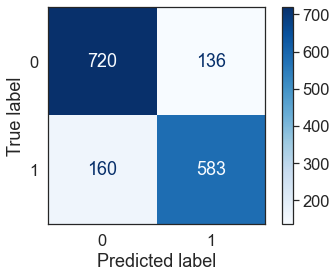

In [33]:
# Run Model 4.1: TfidfVectorizer with RandomForest with main text
run_model_rs(pipe_tvec_rf, params_tvec_rf, cv=5, kind='main', model_name='tvec_rf_main')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 32.51 seconds


Best Score: 0.8327
Best Parameters: {'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'wh

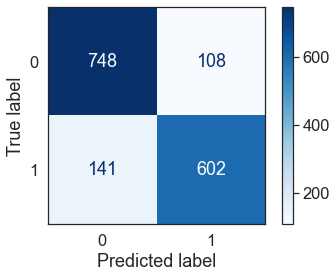

In [34]:
# Run Model 4.2: TfidfVectorizer with RandomForest with stemmed text
run_model_rs(pipe_tvec_rf, params_tvec_rf, cv=5, kind='stem', model_name='tvec_rf_stem')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Time taken: 33.36 seconds


Best Score: 0.8024
Best Parameters: {'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'wh

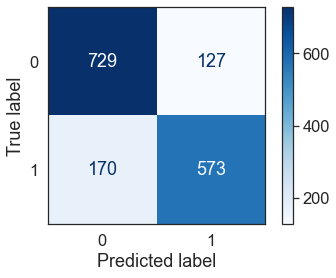

In [35]:
# Run Model 4.3: TfidfVectorizer with RandomForest with lemmatized text
run_model_rs(pipe_tvec_rf, params_tvec_rf, cv=5, kind='lem', model_name='tvec_rf_lem')

## Results Analysis
*Back to [Contents](#Contents:)*

In [36]:
# Check results dictionary
results

{'cvec_nb_main': [0.9209,
  0.8487,
  7.8402,
  0.1513,
  0.8668,
  0.8329,
  0.8183,
  0.8419,
  0.9293],
 'cvec_nb_stem': [0.9343,
  0.8737,
  6.4861,
  0.1263,
  0.891,
  0.8586,
  0.8455,
  0.8677,
  0.9465],
 'cvec_nb_lem': [0.9177,
  0.8468,
  7.7258,
  0.1532,
  0.8668,
  0.8294,
  0.8152,
  0.8402,
  0.9319],
 'tvec_nb_main': [0.9429,
  0.848,
  10.0647,
  0.152,
  0.8358,
  0.8586,
  0.8369,
  0.8363,
  0.9359],
 'tvec_nb_stem': [0.9571,
  0.8699,
  9.1109,
  0.1301,
  0.8694,
  0.8703,
  0.8534,
  0.8613,
  0.9522],
 'tvec_nb_lem': [0.948,
  0.8512,
  10.211,
  0.1488,
  0.8412,
  0.8598,
  0.8389,
  0.84,
  0.9378],
 'cvec_rf_main': [0.9952,
  0.8168,
  17.926,
  0.1832,
  0.786,
  0.8435,
  0.8134,
  0.7995,
  0.8891],
 'cvec_rf_stem': [0.9979,
  0.8418,
  15.6428,
  0.1582,
  0.8183,
  0.8621,
  0.8375,
  0.8278,
  0.9111],
 'cvec_rf_lem': [0.9952,
  0.8186,
  17.7452,
  0.1814,
  0.7887,
  0.8446,
  0.815,
  0.8016,
  0.8869],
 'tvec_rf_main': [0.9936,
  0.8149,
  17.9851

In [37]:
# Convert results dictionary into Dataframe for analysis
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['train_score', 'test_score', 'generalisation',
                           'misclassification', 'sensitivity', 'specificity', 'precision', 'f1_score', 'roc_auc_score'])
results_df

,train_score,test_score,generalisation,misclassification,sensitivity,specificity,precision,f1_score,roc_auc_score
cvec_nb_main,0.9209,0.8487,7.8402,0.1513,0.8668,0.8329,0.8183,0.8419,0.9293
cvec_nb_stem,0.9343,0.8737,6.4861,0.1263,0.8910,0.8586,0.8455,0.8677,0.9465
cvec_nb_lem,0.9177,0.8468,7.7258,0.1532,0.8668,0.8294,0.8152,0.8402,0.9319
tvec_nb_main,0.9429,0.8480,10.0647,0.1520,0.8358,0.8586,0.8369,0.8363,0.9359
tvec_nb_stem,0.9571,0.8699,9.1109,0.1301,0.8694,0.8703,0.8534,0.8613,0.9522
tvec_nb_lem,0.9480,0.8512,10.2110,0.1488,0.8412,0.8598,0.8389,0.8400,0.9378
cvec_rf_main,0.9952,0.8168,17.9260,0.1832,0.7860,0.8435,0.8134,0.7995,0.8891
cvec_rf_stem,0.9979,0.8418,15.6428,0.1582,0.8183,0.8621,0.8375,0.8278,0.9111
cvec_rf_lem,0.9952,0.8186,17.7452,0.1814,0.7887,0.8446,0.8150,0.8016,0.8869
tvec_rf_main,0.9936,0.8149,17.9851,0.1851,0.7847,0.8411,0.8108,0.7975,0.8877


We ran the 3 kinds of text data (main base form, stemmed form & lemmatized form) into our models. In total, we obtained 12 different sets of results for evaluation.

From the table above, we can see that the Random Forest classifier tends to overfit. It gives a high level of accuracy on the training data but does quite poorly on the testing data, giving a high generalisation difference.

Stemming and lemmatizing generates the root word, grouping more words and this possibly allowed the model to run faster. We seem to get better results overall from Porter Stemming for all our models. However, Lemmatizing performance was affected at the expense of the other classification metrics, such as accuracy, sensitivity, specificity, precision and the f1 score.

We will be using **accuracy (test score) and precision** as metrics for this classification problem since true positives and true negatives are important in classifying words correctly. **F1 score and ROC AUC score** are also taken into account here, since there is only a small data imbalance and it places emphasis on the false negative and false positives. From the table, accuracy and f1 score are quite similar and dont differ too much.

Specificity and sensitivity may not be so important here as a wrong classification would not be fatal. Furthermore, the data is not imbalanced to a large extent.

### We will take a look at some of the posts that were wrongly predicted.

In [38]:
# Run a single model (CountVectorizer with NaiveBayes using main text)
rs = RandomizedSearchCV(pipe_cvec_nb, params_cvec_nb, cv=5, verbose=1, n_jobs=-1, n_iter=25, random_state=42)
rs.fit(X_main_train, y_main_train)
print("Train score: ", round(rs.score(X_main_train, y_main_train),4))
print("Test score: ", round(rs.score(X_main_test, y_main_test),4))
y_pred = rs.predict(X_main_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Train score:  0.9209
Test score:  0.8487


In [39]:
# Create a dataframe for the main text test sets to see predictions
text_pred = list(zip(X_main_test, y_main_test, y_pred))
text_pred_df = pd.DataFrame(text_pred, columns=['text', 'actual', 'predicted'])

In [40]:
pd.set_option("display.max_colwidth", 4500)
pd.set_option("display.max_rows", 1000)

# Find those texts with wrong predictions (0 for bicycling, 1 for motorcycles)
# Display only first 10, to see all, please delete .head(10)

text_pred_df[text_pred_df['actual']!=text_pred_df['predicted']].head(10)

,text,actual,predicted
2,"Like is it based on the physical aspects of a bike weight, shape, etc. \n\nI know that right tyre pressure is very crucial for optimum handling. I also know that pressure increases with an increase in temperature of the tyre. the pressure difference from default during street riding might be insignificant but that minute difference can have a major impact on track.\n\n1) Does the manufacturer factor in the temperature increase from cold tyres to hot tires, so does this mean they knowingly recommend low tyre pressure so once the tyre gets warm the tyre pressure would be ideal for handling?\n\n2) If the above case is true then does this mean filling tyre with nitrogen has an adverse affect as the increase in tyre pressure of a nitrogen filled tyre would be less than an air filled tyre, once the tyre gets warm?How do motorcycle manufacturers set default tyre pressure?",1,0
12,New here. His and Hers N(to us)BD x2. Dumb to the hobby.,0,1
22,"I'm from DFW but now I live in a small town in NC. I've found some great twisty roads to rip on in the Uhwarrie area but I don't know a single person who rides so I'm always solo now. I've been lucky and never crashed in my life but it could happen at any time. I'm worried I could get thrown into the woods in the middle of nowhere, my bike could get thrown into the woods and it could be years before my body is found. No one on earth would know where I'm at.\n\nIs there some phone app or something I could buy that could let my family keep track of my location?Is there some kind of phone app or device for my family to track me on a ride?",1,0
23,had my front tire replaced and realized I have no idea what adaptor to use to pump air. is there a name for this ? help appreciated.,0,1
24,the rear wheel locks rather than giving a smooth braking curve. I apply brake and it locks. forwards and gear shifting is ok.\n\n&amp;#x200B;\n\n*Processing video radh3fcs8bb91...*\n\n*Processing video zerrhuto6bb91...*\n\n*Processing img drzr8p566bb91...*\n\n*Processing img f3vyjk566bb91...*\n\n*Processing img eiu9ap566bb91...*help me repair nexus 7 shimano.,0,1
25,"Woman in crash that killed 2 bicyclists did not grasp gravity of tragedy, prosecutor says",0,1
34,Having a dirty bike &gt; not riding,0,1
40,Any pros and cons between the two types of stays? Can't decide what to get.Mudguard/fender stays: U-shaped vs V-shaped,0,1
57,Hi all \n\nI have an MT125 2017 model.\n\nNeed to get both front and rear tyres (all round and all weather tyres)\n\nI can get;\n\n*Pirelli Angel City's for about £120.\n*Metzeler Sportec Street £160.\n*Michelin Road Classics £195.\n\nDoes ANYONE have any experiences or opinions on these three tyres? \n\nI like the look and specs of the Michelin Streets but they are a bit pricey .. does anyone know if they're worth it? \n\nI mean the pirellis are £120 ish and I thought they were awesome tyres from reviews.\n\nThanks in advanceOpinions on specifically 125cc tyres,1,0
62,"On my group ride, two riders next to me crashed. One rider essentially did a front flip and landed on his chest/head. Broke his collarbone. The other suffered minor injuries, but had a large gash on his head from the helmet. Imagine if they weren’t wearing helmets - today could’ve been much worse. \n\nMoral of this story is two things:\n\n1) ALWAYS wear a helmet. They saved two lives today. \n2) ALWAYS be prepared to stop on a dime when drafting. You never know when the person in front will hit their brakes.Group Ride Accident",0,1


Seems like we have to further tune our model to catch more of these wrongly classified posts. Having 'cycling' and 'bicycles' in some of the posts, it should have been quite easy to classify correctly, but model is not predicting it correctly.

## Feature Importance
- For RandomTree models, we will use the built-in Feature Importance to find relevant features, which can help with better understanding of the problem.

*Back to [Contents](#Contents:)*

In [41]:
# Run a single model (CountVectorizer with RandomForest using main text data)
rs = RandomizedSearchCV(pipe_cvec_rf, params_cvec_rf, cv=5, verbose=1, n_jobs=-1, n_iter=25, random_state=42)
rs.fit(X_main_train, y_main_train)
print("Train score: ", round(rs.score(X_main_train, y_main_train),4))
print("Test score: ", round(rs.score(X_main_test, y_main_test),4))
y_pred = rs.predict(X_main_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Train score:  0.9952
Test score:  0.813


In [42]:
feature_names = rs.best_estimator_.named_steps['cvec'].get_feature_names()
rf = rs.best_estimator_.named_steps['rf']

In [43]:
rf.feature_importances_

array([5.82862456e-04, 2.54290995e-05, 4.07300181e-05, ...,
       3.04196843e-05, 5.22173176e-04, 2.00249958e-03])

In [44]:
# zip these items into a list first, so we can convert into a dataframe later
rf_feature_names = zip(feature_names,rf.feature_importances_)

In [45]:
# create function to convert zip into dataframe, then return top 15 values
def feature_df(zip_df):
    df = pd.DataFrame(zip_df, columns=['word', 'rf_gini'])    
    rf_df = df.sort_values(by=['rf_gini'],ascending=False).head(15)
    return rf_df

In [46]:
df_rf_feature_names = feature_df(rf_feature_names)
df_rf_feature_names

,word,rf_gini
2160,honda,0.011446
4960,yamaha,0.010036
3000,ninja,0.009228
1530,exhaust,0.007660
564,bike,0.007629
1015,clutch,0.007412
2506,license,0.007015
2519,like,0.007000
1464,engine,0.006794
3648,riding,0.006484


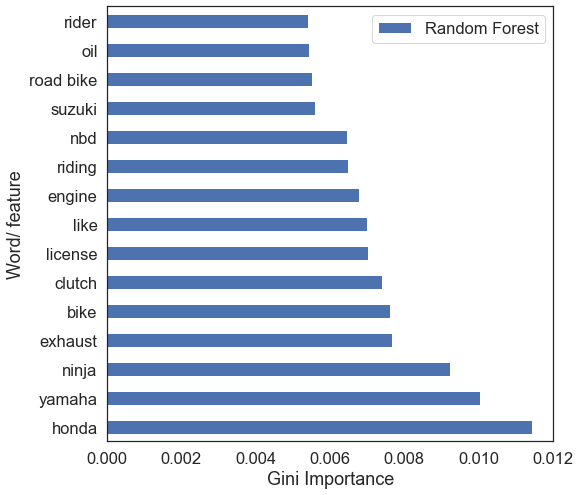

In [47]:
df_rf_feature_names.plot.barh(x='word',y='rf_gini',figsize=(8,8))
plt.legend(['Random Forest']);
plt.ylabel('Word/ feature');
plt.xlabel('Gini Importance');

We can see that motorcycles brand words play a big part in the classification problem. Out of the top 15 features, 6 referred to a particular brand or model (Honda, Yamaha, Ninja, Kawasaki, Suzuki, BMW). Other distinguishing features include throttle, exhaust, engine and license, which likely belonged only to the motorcycles subreddit. A notable feature is "NBD", which stands for "New Bike Day", an abbreviation popular in the cycling community. 

## ROC AUC Curve
*Back to [Contents](#Contents:)*

The curve shows us the behaviour of the classifer for every threshold by plotting the tradeoff between True Positive Rate (TPR) and False Positive Rate (FPR)
- TPR is the recall or sensitivity
- FPR is (1 - specificity)

How to interpret: The higher TPR and the lower FPR for each threshold, the better it is, so classifiers having curves at the top left side are better.

**ROC AUC (Area Under the Receiver Operating Characteristic Curve)** score is a metric used to assess the performance of classification machine learning models. Resulting score represents broadly the model's ability to predict classes correctly.

Advantages of using ROC AUC score
- A simple to track overall performance metric for classification models
- A single metric which covers sensitivity and specificity

Disadvantage of using ROC AUC score
- Does not perform well with heavily imbalanced datasets
- Not very intuitive for end users to understand

In [48]:
rs.fit(X_main_train, y_main_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'cvec__max_features': [2000, 3500,
                                                               5000],
                                        'cvec__ngram_range': [(1, 1), (1, 2)],
                                        'cvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', "you're",
                                                              "you've",
                                                              "you'll", "you'd",
              

In [49]:
y_pred = rs.predict(X_main_test)
y_proba = rs.predict_proba(X_main_test)
auc = round(roc_auc_score(y_main_test, y_proba[:,1]),4)

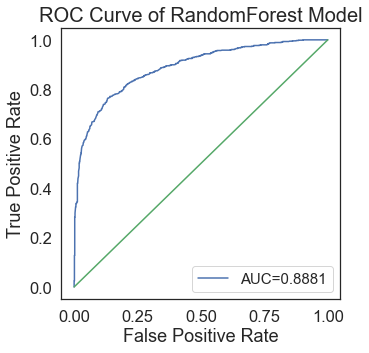

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f'AUC={auc}').plot()
    roc_display.figure_.set_size_inches(5,5)
    
    plt.title('ROC Curve of RandomForest Model', fontsize=20)
    plt.plot([0, 1], [0, 1], color = 'g')
    plt.legend(fontsize=15, loc='lower right')
    
# Plots the ROC curve using the sklearn methods - Good plot
plot_sklearn_roc_curve(y_main_test, y_proba[:, 1])

The ROC AUC score ranges from 0.5 to 1, where 1 is a perfect score and 0.5 means the model is as good as random. In our case, a 0.89 score shows that the RandomForest is giving good performance.

## Conclusion & Recommendations
*Back to [Contents](#Contents:)*

In [51]:
results_df.iloc[[1,4,7,10],[0,1,2,6,7,8]]

,train_score,test_score,generalisation,precision,f1_score,roc_auc_score
cvec_nb_stem,0.9343,0.8737,6.4861,0.8455,0.8677,0.9465
tvec_nb_stem,0.9571,0.8699,9.1109,0.8534,0.8613,0.9522
cvec_rf_stem,0.9979,0.8418,15.6428,0.8375,0.8278,0.9111
tvec_rf_stem,0.9965,0.8443,15.2735,0.8479,0.8286,0.9138


We will select the **CountVectorizer with the Multinomial Naive Bayes model** as it has good generalisation, accuracy, precision, f1 scores and ROC-AUC scores, compared to the other models. We will apply this model after Porter Stemming, whose overall performance is better than when on its base form or after lemmatizing.

The Random Forest models show signs of overfitting and further work would have to be done to optimise and tune the hyperparameters. The accuracy, precision and f1 scores are also not as high as when done with the Naive Bayes models.

### Recommendations:
- There were still some spam posts left over, so more thorough cleaning would have to be done. Some posts also had weird string characters left despite one round of cleaning.
- Possibly test out on other models other than Naive Bayes and Random Forest.
- We could also explore new features within Reddit such as the upvotes and downvotes, as well as post comments.
- As this is a fairly balanced dataset, the metrics are easy to compare. In the future, if we were to encounter highly imbalanced dateset, the use of sensitivity and specificity would be of greater use. The ROC-AUC curve cannot be used and would have to be substituted with the Precision Recall curve.

## References
Special thanks and credit given to these projects for allowing me to get started on this project,<br>
And for also teaching me different techniques and methods to approach the project

*Back to [Contents](#Contents:)*

- https://github.com/KellySlatery/nlp_project_dsi
- https://github.com/chawlasahaj/dsiprojects/tree/main/NLP-classification
- https://github.com/twludlow/portfolio-03-webscraping-nlp
- https://github.com/cheekeet86/project_3
- https://github.com/zzeniale/Subreddit-classification
- https://github.com/gabrielpprieto/reddit_nlp
- https://github.com/doscsy12/GA_projects/tree/master/project_3
- https://github.com/yufung/dsi-project-3/blob/master/code/subreddit_classifier.ipynb
- https://github.com/gbkgwyneth/GA-DSI-project-03/blob/master/code/Project3.ipynb
- https://mljar.com/blog/feature-importance-in-random-forest/
- https://github.com/osyounis/reddit_nlp/blob/main/code/Project_3_Main_Code_OSY.ipynb